## Welcome

This is material for the **Synthetic Control** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.vectors import IntVector

import plotnine as p
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file):
    full_path = "https://raw.github.com/scunning1975/mixtape/master/" + file
    
    return pd.read_stata(full_path)

## Prison Construction and Black Male Incarceration


In [3]:
texas = read_data("texas.dta")

In [4]:
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
Synth = importr('Synth')

In [5]:
control_units = [1, 2, 4, 5, 6] +\
    list(range(8, 14)) + list(range(15,43)) +\
    list(range(44, 47)) + [49, 50, 51, 53,54,55,56]

robjects.globalenv['texas'] = texas

predictors = robjects.vectors.StrVector(['poverty', 'income'])
sp = robjects.vectors.ListVector({'1': ['bmprison', IntVector([1988, 1990, 1991, 1992]), 'mean'], 
                                  '2': ['alcohol', 1990, 'mean'], 
                                  '3': ['aidscapita', IntVector([1990, 1991]), 'mean'], 
                                  '4': ['black', IntVector([1990, 1991, 1992]), 'mean'], 
                                  '5': ['perc1519', 1990, 'mean']})

dataprep_out = Synth.dataprep(texas, 
    predictors = predictors,
    predictors_op="mean",
    time_predictors_prior=np.arange(1985, 1994),
    special_predictors=sp,
    dependent='bmprison',
    unit_variable='statefip',
    unit_names_variable='state',
    time_variable='year',
    treatment_identifier=48,
    controls_identifier=control_units,
    time_optimize_ssr=np.arange(1985, 1994),
    time_plot=np.arange(1985, 2001))

synth_out = Synth.synth(data_prep_obj = dataprep_out)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 2019839 

solution.v:
 0.06843543 0.02849309 0.8949852 3.30278e-05 0.000122374 0.007929645 1.2876e-06 

solution.w:
 2.1036e-06 1.638e-07 1.2605e-06 8.781e-06 0.3420653 3.717e-07 1.469e-07 1.663e-07 3.97e-08 0.2963684 2.978e-07 1.866e-07 6.0836e-06 6.135e-07 1.2125e-06 9.987e-07 5.646e-07 5.5707e-06 0.3613969 1.0905e-06 2.03e-07 2.069e-07 3.0885e-06 3.587e-07 4.5e-09 9.953e-07 4.9594e-06 6.338e-07 2.669e-07 2.468e-07 2.597e-07 4.057e-06 3.443e-07 7.378e-07 3.7061e-06 6.8669e-06 2.7571e-06 7.46e-07 1.136e-06 3.282e-07 2.3e-09 2.8444e-06 8.1658e-05 7.937e-07 3.366e-07 3.824e-07 2.04033e-05 7.517e-07 7.518e-07 



In [6]:
weights = synth_out.rx['solution.w'][0]
ct_weights = pd.DataFrame({'ct_weights':weights.flatten(), 'statefip':control_units})
ct_weights.head()

,ct_weights,statefip
0,2.103617e-06,1
1,1.638053e-07,2
2,1.260496e-06,4
3,8.781002e-06,5
4,3.420653e-01,6


In [7]:
texas = pd.merge(ct_weights, texas, how='right', on='statefip')

Text(0.5, 1.0, 'Synthetic Control Performance')

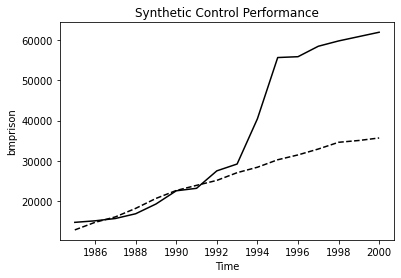

In [8]:
texas = texas.sort_values('year')
ct = texas.groupby('year').apply(lambda x : np.sum(x['ct_weights']*x['bmprison']))
treated = texas[texas.statefip==48]['bmprison'].values
years = texas.year.unique()


plt.plot(years, ct, linestyle='--', color='black', label='control')
plt.plot(years, treated, linestyle='-', color='black', label='treated')
plt.ylabel('bmprison')
plt.xlabel('Time')
plt.title('Synthetic Control Performance')

Text(0.5, 1.0, 'Treated - Control')

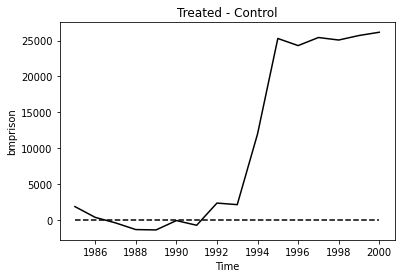

In [9]:
ct_diff = treated - ct

plt.plot(years, np.zeros(len(years)), linestyle='--', color='black', label='control')
plt.plot(years, ct_diff, linestyle='-', color='black', label='treated')
plt.ylabel('bmprison')
plt.xlabel('Time')
plt.title('Treated - Control')


#### Questions
- In your own words, what do you think the identifying assumptions are for synthetic control to be consistent? 
- What role, if any, does parallel trends play in synthetic control?
- Who is the unit with the largest ratio of post to pre RMSPE?  
- Compare the unit with the largest post to pre RMSPE estimated effect to the Texas effect.  How do the weights compare?  How do the size of the effects compare?  How do the ``signs`` of the effects compare?
- Can you improve on my fit by experimenting with different combinations? Do so and report your analysis.
- Report results from a variety of different specifications.  How robust does the prison effect appear to be?

